# NNLM 模型
**Definition**: A n-gram is a chunk of n consecutive words.  
• **uni**grams: “the”, “students”, “opened”, ”their”  
• **bi**grams: “the students”, “students opened”, “opened their”  
• **tri**grams: “the students opened”, “students opened their”  
• 4-grams: “the students opened their  
**Idea**: Collect statistics about how frequent different n-grams are and use these to
predict next word.

In [50]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


%matplotlib inline

## 构建数据

In [19]:
# 数据我们使用的是莎士比亚的14行诗
test_sentence = """When forty winters shall besiege thy brow,
                And dig deep trenches in thy beauty's field,
                Thy youth's proud livery so gazed on now,
                Will be a totter'd weed of small worth held:
                Then being asked, where all thy beauty lies,
                Where all the treasure of thy lusty days;
                To say, within thine own deep sunken eyes,
                Were an all-eating shame, and thriftless praise.
                How much more praise deserv'd thy beauty's use,
                If thou couldst answer 'This fair child of mine
                Shall sum my count, and make my old excuse,'
                Proving his beauty by succession thine!
                This were to be new made when thou art old,
                And see thy blood warm when thou feel'st it cold.""".split()


# 将单词序列转化为数据元组列表，
# 其中的每个元组格式为([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i+1]], test_sentence[i+2])
            for i in range(len(test_sentence) - 2)]

In [20]:
# 打印出前3条数据，注意观察数据的结构
trigrams[0]

(['When', 'forty'], 'winters')

In [21]:
# 给14行诗建立单词表
# set 即去除重复的词
vocab = set(test_sentence)
# 建立词典，它比单词表多了每个词的索引
word_to_ix = {word: i for i, word in enumerate(vocab)}

## 构建模型
模型架构：  
1. 模型一共三层，第一层是映射层，将n个单词映射为对应word embeddings的拼接，其实这一层就是MLP的输入层；第二层是隐藏层，激活函数用tanh；第三层是输出层，因为是语言模型，需要根据前n个单词预测下一个单词，所以是一个多分类器，用softmax。整个模型最大的计算量集中在最后一层上，因为一般来说词汇表都很大，需要计算每个单词的条件概率，是整个模型的计算瓶颈。

2. 这里，需要注意的是需要提前初始化一个word embedding矩阵，每一行表示一个单词的向量。词向量也是训练参数，在每次训练中进行更新。这里可以看出词向量是语言模型的一个附属品，因为语言模型本身的工作是为了估计给定的一句话有多像人类的话，但从后来的研究发现，语言模型成了一个非常好的工具。

3. softmax是一个非常低效的处理方式，需要先计算每个单词的概率，并且还要计算指数，指数在计算机中都是用级数来近似的，计算复杂度很高，最后再做归一化处理。此后很多研究都针对这个问题进行了优化，比如层级softmax，比如softmax tree。
![](./imgs/ngram.png)

In [51]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):

        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):

        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        # 通过 log_softmax 方法将结果映射为概率的log
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [46]:
losses = []
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
loss_function = nn.NLLLoss()
# 单词表的大小、嵌入维度、上下文长度
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [48]:
model

NGramLanguageModeler(
  (embeddings): Embedding(97, 10)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=97, bias=True)
)

In [47]:
for epoch in tqdm(range(1000)):

    total_loss = 0
    # 循环context上下文，比如：['When', 'forty']
    # target，比如：winters
    for context, target in trigrams:
        # 将context如“['When', 'forty']”
        # 转化为索引，如[68, 15]
        context_idxs = list(map(lambda w: word_to_ix[w], context))
        context_var = autograd.Variable(torch.LongTensor(context_idxs))
        # 步骤2：清空梯度值，防止上次的梯度累计
        model.zero_grad()
        # 步骤3：运行网络的正向传播，获得 log 概率
        log_probs = model(context_var)
        loss = loss_function(log_probs, autograd.Variable(
            torch.LongTensor([word_to_ix[target]])))
        # 步骤5：进行反向传播并更新梯度
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    if epoch % 100 == 0:
        print("The loss {} of {}".format(loss.data, epoch))

    losses.append(total_loss)


print('Finished')

  0%|          | 4/1000 [00:00<01:06, 14.93it/s]

The loss 4.66568660736084 of 0


 10%|█         | 104/1000 [00:06<00:56, 15.82it/s]

The loss 3.462538719177246 of 100


 20%|██        | 204/1000 [00:12<00:47, 16.65it/s]

The loss 1.0630207061767578 of 200


 30%|███       | 304/1000 [00:18<00:42, 16.49it/s]

The loss 0.23098227381706238 of 300


 40%|████      | 402/1000 [00:24<00:40, 14.83it/s]

The loss 0.10503446310758591 of 400


 50%|█████     | 504/1000 [00:31<00:30, 16.10it/s]

The loss 0.06432755291461945 of 500


 60%|██████    | 604/1000 [00:37<00:23, 16.52it/s]

The loss 0.04525027051568031 of 600


 70%|███████   | 702/1000 [00:44<00:20, 14.62it/s]

The loss 0.034482017159461975 of 700


 80%|████████  | 802/1000 [00:51<00:16, 11.90it/s]

The loss 0.02763105183839798 of 800


 90%|█████████ | 902/1000 [00:58<00:07, 13.14it/s]

The loss 0.022926034405827522 of 900


100%|██████████| 1000/1000 [01:04<00:00, 15.46it/s]

Finished


## 分析
模型的优缺点:  
![](./imgs/weak.png)

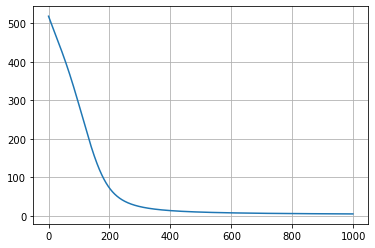

In [53]:
plt.figure()
plt.grid()
plt.plot(losses)
plt.show()

# 参考
[原文地址](https://link.zhihu.com/?target=https%3A//www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)  
[【论文阅读】A Neural Probabilistic Language Mode](https://blog.csdn.net/u014568072/article/details/78557837?spm=1001.2101.3001.6650.10&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EOPENSEARCH%7ERate-10.topblog&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EOPENSEARCH%7ERate-10.topblog&utm_relevant_index=11)